# January 15: Linear Regression

**Constants:** Define our data set $[(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)]$ and nudging factor $k$

In [ ]:
# List of all data points
data = [(0, 1), (1, 3), (3, 4), (5, 6), (6, 5)]
n = len(data)

# The "nudging" factor, k
k = 0.005

Plot our data points:

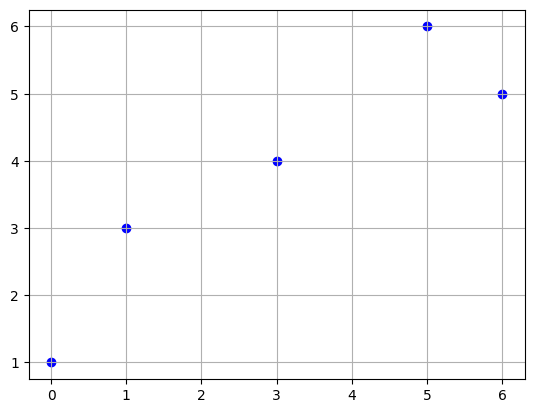

In [ ]:
import matplotlib.pyplot as plt

x_coords, y_coords = zip(*data)  # Separate x and y values
plt.scatter(x_coords, y_coords, color='blue')
plt.grid(True)
plt.show()

Calculate our heuristic values for $a$ and $b$: $a = 0$, $b = m_\text{sec}=\frac{y_n - y_1}{x_n - x_1}$

*Note:* If $x_n - x_1 = 0$, we will get a `ZeroDivisionError`. We can assume $b = 0$ in these cases.

In [ ]:
x_n, y_n = data[-1]
x_1, y_1 = data[0]

a = 0
try:
    b = (y_n - y_1) / (x_n - x_1)
except ZeroDivisionError:
    b = 0

# Let's also track the number of iterations so far:
iterations = 0

Define the model $ŷ(x) = a + bx$

In [ ]:
def y_hat(x: float) -> float:
    return a + b * x

Define the function that calculates the mean-squared error, i.e. our loss function

$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (ŷ(x_i) - y_i)^2$

In [ ]:
def loss() -> float:
    return sum((y_hat(x) - y) ** 2 for x, y in data) / n

Define functions that calculate:

$\Delta a = \frac{\partial}{\partial a}\text{MSE} = \frac{2}{n} \sum_{i=1}^{n} ( ŷ(x_i) - y_i )$ and

$\Delta b = \frac{\partial}{\partial b}\text{MSE} = \frac{2}{n} \sum_{i=1}^{n} x_i( ŷ(x_i) - y_i)$

In [ ]:
def delta_a() -> float:
    return 2 / n * sum(y_hat(x) - y for x, y in data)

def delta_b() -> float:
    return 2 / n * sum(x * (y_hat(x) - y) for x, y in data)

Define a function that nudges $a$ and $b$ by $k\Delta a$ and $k\Delta b$. This is one "iteration".

In [ ]:
def nudge():
    global a, b, iterations

    a -= k * delta_a()  # Note we are going in the opposite direction!
    b -= k * delta_b()

    iterations += 1  # Increment the number of iterations

Run an iteration and plot the new regression $ŷ = a + bx$:

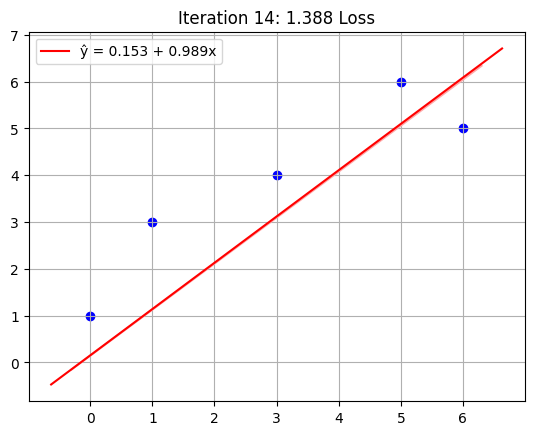

In [ ]:
def plot_regression_line(*, color: str = 'red'):
    return plt.plot(plt.xlim(), [y_hat(x) for x in plt.xlim()], color=color)

# Plot data points and old regression
plt.scatter(x_coords, y_coords, color='blue')
plot_regression_line(color='#ffaaaa')

# Perform one iteration
nudge()

plt.title(f"Iteration {iterations}: {loss():.3f} Loss")

# Plot new regression
line, = plot_regression_line()
line.set_label(f"ŷ = {a:.3f} + {b:.3f}x")  # Regression equation

plt.grid(True)
plt.legend()
plt.show()

Repeatedly call `nudge()` until the mean-squared error begins *converging*.

Eventually, the mean-squared error may stop decreasing. This is a good stopping point for our regression.

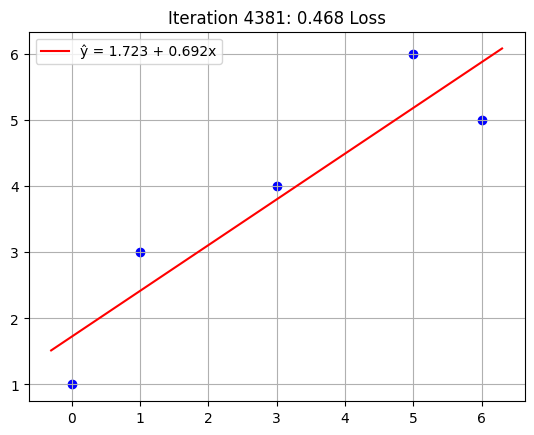

In [ ]:
prev = loss()
while loss() <= prev:  # Keep "nudging" as the loss is decreasing
    prev = loss()
    nudge()

# Plot final regression
plt.title(f"Iteration {iterations}: {loss():.3f} Loss")
plt.scatter(x_coords, y_coords, color='blue')

line, = plot_regression_line()
line.set_label(f"ŷ = {a:.3f} + {b:.3f}x")  # Regression equation

plt.grid(True)
plt.legend()
plt.show()

We can finally combine this regression algorithm into one single function:

In [79]:
from typing import NamedTuple

class Regression(NamedTuple):
    a: float
    b: float
    loss: float
    iterations: int

    def predict(self, x: float) -> float:
        return self.a + self.b * x

    def __str__(self) -> str:
        sign = '+' if self.b >= 0 else '-'
        return f"ŷ = {self.a:.4f} {sign} {abs(self.b):.4f}x"

def loss(data: list[tuple[float, float]], *, a: float, b: float) -> float:
    """Computes the mean-squared error of the data set with regression a + bx."""
    return sum((a + b * x - y) ** 2 for x, y in data) / len(data)

def lin_reg(
    data: list[tuple[float, float]],
    *,
    k: float = 0.005,
    max_iterations: int = 10_000,
) -> Regression:
    """Takes a set of data points and computes a linear regression model with nudging factor k."""

    n = len(data)
    c = 2 / n  # Precompute 2 / n when calculating ∆a and ∆b

    # Compute heuristics
    x_n, y_n = data[-1]
    x_1, y_1 = data[0]

    a = 0
    try:
        b = (y_n - y_1) / (x_n - x_1)
    except ZeroDivisionError:
        b = 0

    iterations = 0
    prev_loss = float('inf')

    while True:
        delta_a = c * sum(a + b * x - y for x, y in data)
        delta_b = c * sum(x * (a + b * x - y) for x, y in data)

        new_a = a - k * delta_a
        new_b = b - k * delta_b
        iterations += 1

        new_loss = loss(data, a=new_a, b=new_b)
        if prev_loss <= new_loss:  # Are we converging?
            # Since the previous regression had lower loss, return that one
            return Regression(a, b, prev_loss, iterations - 1)

        if iterations >= max_iterations:
            return Regression(new_a, new_b, new_loss, iterations)

        a = new_a
        b = new_b
        prev_loss = new_loss

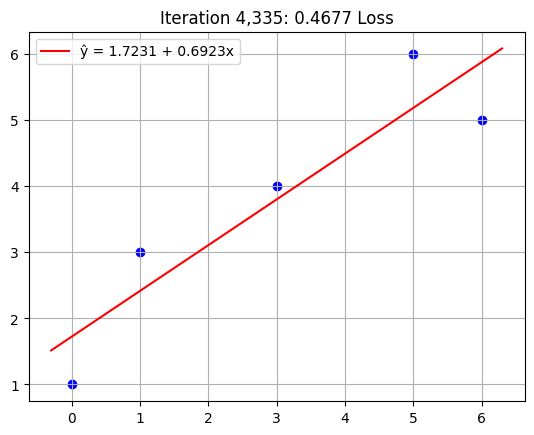

In [80]:
# Try the function
data = [(0, 1), (1, 3), (3, 4), (5, 6), (6, 5)]
reg = lin_reg(data, k=0.005)

# Plot final regression
plt.title(f"Iteration {reg.iterations:,}: {reg.loss:.4f} Loss")
plt.scatter(*zip(*data), color='blue')
plt.plot(
    plt.xlim(),
    [reg.predict(x) for x in plt.xlim()],
    color='red',
    label=reg,
)
plt.grid(True)
plt.legend()
plt.show()